In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [14]:
PATH = '../voronoi/2K'
VERTEX_PATH = PATH + '/vertices.txt'
RIDGES_PATH = PATH + '/ridges.txt'
ORIS_PATH = PATH + '/oris.txt'
SE_PATH = PATH + '/SE/uniform.txt'

In [15]:
ridges = np.loadtxt(RIDGES_PATH, dtype = int)
vertices = np.loadtxt(VERTEX_PATH)
oris = np.loadtxt(ORIS_PATH)
SE = np.loadtxt(SE_PATH)

In [7]:
def wrap_dist(dest, orig, DOMAIN_BOUND):
    delta = dest - orig
    if delta[0] > DOMAIN_BOUND*0.5:
        delta[0] = delta[0] - DOMAIN_BOUND
    elif delta[0] < -0.5*DOMAIN_BOUND:
        delta[0] = DOMAIN_BOUND + delta[0]
    if delta[1] > 0.5*DOMAIN_BOUND:
        delta[1] = delta[1] - DOMAIN_BOUND
    elif delta[1] < -0.5*DOMAIN_BOUND:
        delta[1] = DOMAIN_BOUND + delta[1]
    return delta

In [8]:
def _adjust_points(xpos, ypos, DOMAIN_BOUND):
    xret = np.zeros(len(xpos))
    yret = np.zeros(len(xpos))
    xret[:] = xpos
    yret[:] = ypos
    for i in range(1, len(xpos)):
        curr = np.array([xret[i], yret[i]])
        prev = np.array([xret[i - 1], yret[i - 1]])
        delta = wrap_dist(curr, prev, DOMAIN_BOUND)
        curr = prev + delta
        xret[i] = curr[0]
        yret[i] = curr[1]
    return xret, yret

In [9]:
def plot_boundaries(boundarys, domain=1.0, lw=1.0, figsize=(10, 7)):
    """
        Plot boundaries lines
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    coords = [bnd for bnd in boundarys]
    coords2 = [bnd+[domain,0] for bnd in boundarys if np.any(bnd[:,0] < 0)]
    coords3 = [bnd+[-domain,0] for bnd in boundarys if np.any(bnd[:,0] > domain)]
    coords4 = [bnd+[0,domain] for bnd in boundarys if np.any(bnd[:,1] < 0)]
    coords5 = [bnd+[0,-domain] for bnd in boundarys if np.any(bnd[:,1] > domain)]
    coords6 = [bnd+[domain,domain] for bnd in boundarys \
                if np.any(bnd[:,0] < 0) and np.any(bnd[:,1] < 0)]
    coords7 = [bnd+[-domain,-domain] for bnd in boundarys \
                if np.any(bnd[:,0] > domain) and np.any(bnd[:,1] > domain)]
    coords8 = [bnd+[-domain,domain] for bnd in boundarys \
                if np.any(bnd[:,0] > domain) and np.any(bnd[:,1] < 0)]
    coords9 = [bnd+[domain,-domain] for bnd in boundarys \
                if np.any(bnd[:,0] < 0) and np.any(bnd[:,1] > domain)]
    coords = coords+coords2+coords3+coords4+coords5+coords6+coords7+coords8+coords9
    bnd_collection = LineCollection(coords, lw=lw, color='k')
    ax.add_collection(bnd_collection)
    return ax

In [10]:
def get_all_bounds_coords(ridges, vertices):
    boundarys = np.array([[[vertices[bound[0]][0], 
                        vertices[bound[0]][1]],
                       [vertices[bound[1]][0], 
                        vertices[bound[1]][1]]] for bound in ridges])
    return boundarys

In [11]:
def adjust_all_bounds(boundarys_mod, bound_domain):
    boundarys_mod = np.zeros(boundarys.shape)
    for index, bound in enumerate(boundarys):
        ret = _adjust_points(bound[:,0], bound[:,1], bound_domain)
        boundarys_mod[index][:, 0] = ret[0]
        boundarys_mod[index][:, 1] = ret[1]
    return boundarys_mod

In [12]:
DOMAIN_BOUND = 1.0
boundarys = get_all_bounds_coords(ridges, vertices)
boundarys_mod = adjust_all_bounds(boundarys, DOMAIN_BOUND)

# Plots:

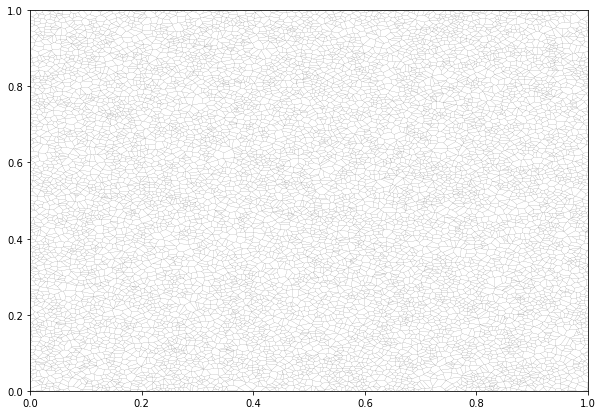

In [13]:
figsize = (10, 7)
LINE_WIDTH = 0.1
bound_plot = plot_boundaries(boundarys_mod, DOMAIN_BOUND, LINE_WIDTH, figsize)

# Código de legado

In [ ]:
def plot_grains(vertices, ridges, figsize=(10,7), vertex_plot = True, vertex_size = 3):
    plt.figure(figsize=figsize)
    vertex_total = vertices.shape[0]    
    # Quadrants for periodic boundary conditions
    quadrants = np.concatenate((
                                        vertices, # Quinto cuadrante
                                        vertices + [-1., 1.], # Primer cuadrante
                                        vertices + [0., 1.], # Segundo cuadrante
                                        vertices + [1., 1.], # Tercer cuadrante
                                        vertices + [-1., 0.], # Cuarto cuadrante
                                        vertices + [1., 0.], # Sexto cuadrante
                                        vertices + [-1., -1.], # Séptimo cuadrante
                                        vertices + [0., -1.], # Octavo cuadrante
                                        vertices + [1., -1.] # Noveno cuadrante
                                        ), axis=0)
    """
    ----------------------------------
             -             -
      1      -     2       -     3
    ----------------------------------
             -             -
      4      -     5       -     6
    ----------------------------------
             -             -
      7      -     8       -     9
    ----------------------------------
    """
    for vpair in ridges:
        v0 = vertices[vpair[0]]
        v1 = vertices[vpair[1]]
        """
            Heuristica que indica si 2 vertices estan conectados a traves de bordes.
            Si la distancia entre 2 vertices conectados es >= 0.5, estan conectados a traves de un borde.
        """
        if np.linalg.norm(v1-v0) < 0.5:   
            # Draw a line from v0 to v1.
            plt.plot([v0[0], v1[0]], [v0[1], v1[1]], 'k', linewidth=0.5)
        else:
            min_v0 = (np.infty,-1)
            min_v1 = (np.infty,-1)
            # Se escoje el cuadrante con la menor distancia entre el par de vertices y se hace plot a 2 lineas.
            for vertex_number in range(vertex_total, quadrants.shape[0], vertex_total):
                norm_v0 = np.linalg.norm(quadrants[vertex_number + vpair[1]] - v0)
                norm_v1 = np.linalg.norm(quadrants[vertex_number + vpair[0]] - v1)
                if norm_v0 < min_v0[0]:
                    min_v0 = (norm_v0, vertex_number)
                if norm_v1 < min_v1[0]:
                    min_v1 = (norm_v1, vertex_number)
            plt.plot([v0[0], quadrants[min_v0[1] + vpair[1]][0]], [v0[1], quadrants[min_v0[1] + vpair[1]][1]], 'k', linewidth=0.5)
            plt.plot([v1[0], quadrants[min_v1[1] + vpair[0]][0]], [v1[1], quadrants[min_v1[1] + vpair[0]][1]], 'k', linewidth=0.5)
    # Se toma solo el plot de el quinto cuadrante.
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    # Mark the Voronoi vertices if vertex_plot = True.
    if vertex_plot:
        plt.plot(vertices[:,0], vertices[:, 1], "ko", ms=vertex_size)
    plt.show()